In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview
In the methodology_kmeans.ipynb, all data were standardized and normalized. Therefore, this time, appropriate data preprocessing methods will be executed for each feature based on the suitability of the data. The results will be judged based on the outcomes of k-means.

1. Remove one of the features that have a high correlation coefficient.
2. Look at `df.describe` to try the appropriate data preprocessing method based on the distribution of the data.

The purporse of this notebook is to improve the performance of k-means model.

## Load Data

In [2]:
from utils import get_df_description

# load df
df_train = pd.read_csv('../datasets/df_train.csv')
print(df_train.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df_train, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


In [3]:
## Selecting numeric columns

df_numeric = df_train[['customer_unique_id'] + df_train.select_dtypes(include=['number']).columns.tolist()]
df_numeric = df_numeric.dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 14)


,customer_unique_id,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,0,1
2,0000f46a3911fa3c0805444483337064,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,0,0
4,0004aac84e0df4da2b147fca70cf8255,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,0,1


In [4]:
# We have rfm_score, so drop frequency and monetary. Also, drop fo_voucher_used because we have fo_voucher_amount
df_numeric = df_numeric.drop(columns=['frequency', 'monetary', 'fo_voucher_used'])

# df_numeric = df_numeric.sample(n=5000, random_state=42)

print(df_numeric.shape)
df_numeric.describe()

(92633, 11)


,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
count,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000,92633.000000
mean,0.030777,285.896808,0.538653,159.989520,0.905790,0.770276,-11.891000,4.153952,3.479034,0.419634
std,0.172715,152.614536,0.645072,219.023904,0.292123,0.420657,10.118954,1.284774,28.344362,0.493502
min,0.000000,0.000000,0.000000,9.590000,0.000000,0.000000,-147.000000,1.000000,0.000000,0.000000
25%,0.000000,162.000000,0.000000,61.940000,1.000000,1.000000,-17.000000,4.000000,0.000000,0.000000
50%,0.000000,267.000000,0.000000,105.280000,1.000000,1.000000,-12.000000,5.000000,0.000000,0.000000
75%,0.000000,394.000000,1.000000,176.330000,1.000000,1.000000,-7.000000,5.000000,0.000000,1.000000
max,1.000000,744.000000,3.000000,13664.080000,1.000000,1.000000,188.000000,5.000000,1839.050000,1.000000


In [5]:
df_numeric.drop(columns=['customer_unique_id']).skew()

repeater                     5.433610
recency                      0.448919
rfm_score                    0.951689
fo_payment_value             9.289699
fo_is_daytime               -2.778271
fo_is_weekday               -1.285046
fo_delivery_delay_days       2.001439
fo_review_score_mean        -1.479729
fo_voucher_payment_value    21.830950
customer_in_sao_paulo        0.325702
dtype: float64

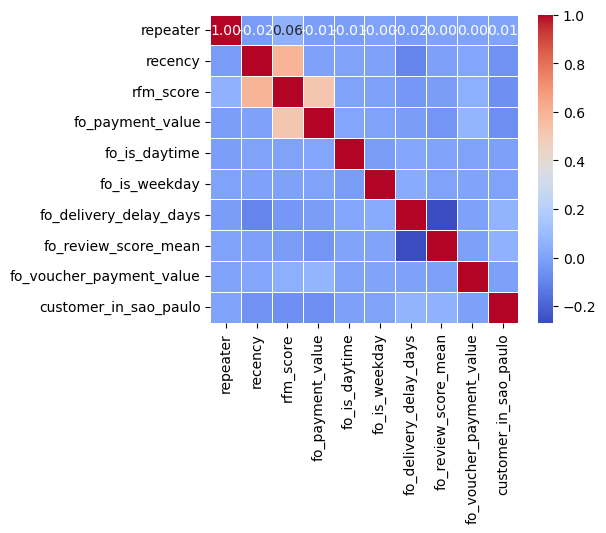

In [6]:
corr = df_numeric.drop(columns=['customer_unique_id']).corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

In [7]:
# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# robust_yeojohnson_pipeline = Pipeline(steps=[
#     ('robust', RobustScaler()),
#     ('yeojohnson', PowerTransformer(method='yeo-johnson'))
# ])

# Creating a pipeline for applying preprocessing
preprocessors = ColumnTransformer(transformers=[
    ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['fo_delivery_delay_days']),
    ('boxcox', PowerTransformer(method='box-cox'), ['fo_payment_value']),
    ('std', StandardScaler(), ['recency', 'rfm_score', 'fo_review_score_mean']),
    ('robust', RobustScaler(), ['fo_voucher_payment_value']),
    # ('robust_yeojohnson', robust_yeojohnson_pipeline, ['fo_voucher_payment_value']),
])

# Applying the pipeline to the DataFrame
df_transformed = preprocessors.fit_transform(df_numeric.drop(columns=['customer_unique_id']))

# Adjusting column names in the transformed DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=[
    'fo_delivery_delay_days_yj',
    'fo_payment_value_boxcox',
    'recency_std', 'rfm_score_std', 'fo_review_score_mean_std',
    'fo_voucher_payment_value_robust',
    # 'fo_voucher_payment_value_robust_yj'
])

# Add binary features to the transformed DataFrame
binary_features = df_train.loc[df_numeric.index, ['fo_is_daytime', 'fo_is_weekday']]
df_transformed = pd.concat([df_transformed, binary_features.reset_index(drop=True)], axis=1)

# Print the skewness of the transformed features
print(df_transformed.skew())

df_transformed.describe()


fo_delivery_delay_days_yj          -0.748871
fo_payment_value_boxcox             0.005261
recency_std                         0.448919
rfm_score_std                       0.951689
fo_review_score_mean_std           -1.479729
fo_voucher_payment_value_robust    21.830950
fo_is_daytime                      -2.778271
fo_is_weekday                      -1.285046
dtype: float64


,fo_delivery_delay_days_yj,fo_payment_value_boxcox,recency_std,rfm_score_std,fo_review_score_mean_std,fo_voucher_payment_value_robust,fo_is_daytime,fo_is_weekday
count,9.263300e+04,9.263300e+04,9.263300e+04,9.263300e+04,9.263300e+04,92633.000000,92633.000000,92633.000000
mean,3.034455e-16,-1.272999e-15,5.476747e-17,-5.814250e-17,-2.182261e-17,3.479034,0.905790,0.770276
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,28.344362,0.292123,0.420657
min,-1.984097e+01,-3.917514e+00,-1.873336e+00,-8.350313e-01,-2.454882e+00,0.000000,0.000000,0.000000
25%,-5.096232e-01,-6.748014e-01,-8.118327e-01,-8.350313e-01,-1.198284e-01,0.000000,1.000000,1.000000
50%,7.183929e-02,3.983994e-02,-1.238212e-01,-8.350313e-01,6.585227e-01,0.000000,1.000000,1.000000
75%,6.186243e-01,6.630145e-01,7.083452e-01,7.151912e-01,6.585227e-01,0.000000,1.000000,1.000000
max,8.684104e+00,3.939945e+00,3.001717e+00,3.815636e+00,6.585227e-01,1839.050000,1.000000,1.000000


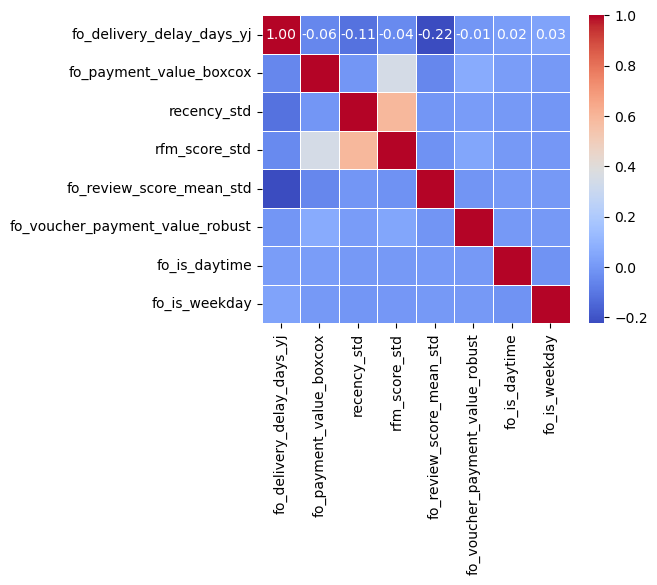

In [8]:
corr = df_transformed.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

## k-means

In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        s_score = silhouette_score(data, labels)
        dbi_score = davies_bouldin_score(data, labels)
        silhouette_scores.append(s_score)
        dbi_scores.append(dbi_score)
        print(n_clusters, s_score, dbi_score)

    # Returning all silhouette and DBI scores
    return silhouette_scores, dbi_scores

2 0.9653936542490787 0.4810571658826113
3 0.9538782090278254 0.418717646648465
4 0.9428634505109108 0.46175369272358835
5 0.938911167000028 0.478300396654528
6 0.92430160049851 0.4738268833258385
7 0.9226915944552364 0.4826763695817287
8 0.922731576334528 0.4899162891189871
9 0.9171759433209685 0.49581713825357343
10 0.9170515757147 0.485522753466834


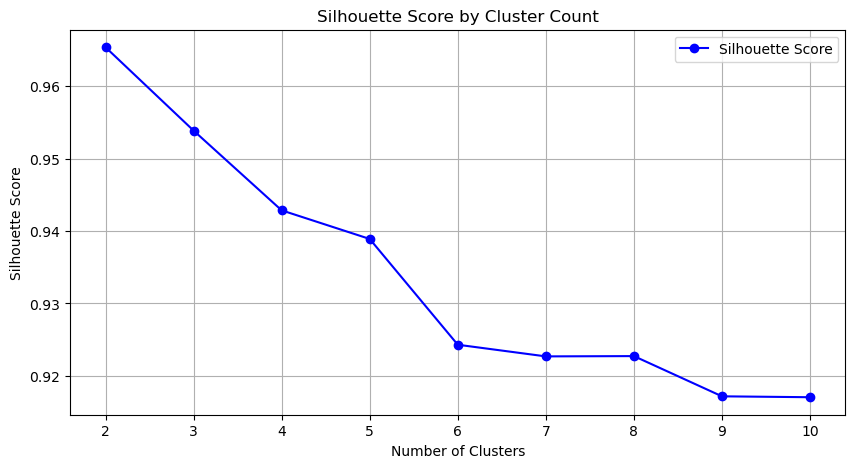

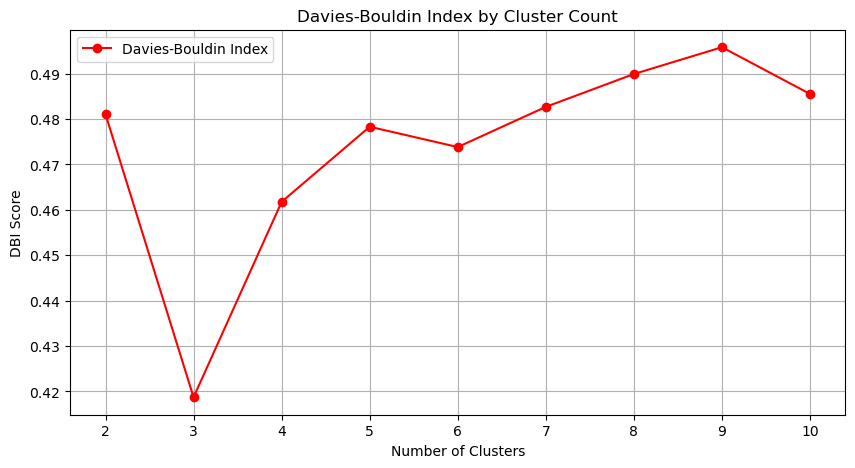

In [10]:
silhouette_scores, dbi_scores = find_optimal_clusters(df_transformed, max_clusters=10)

clusters_range = range(2, 11)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, dbi_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.show()

# It took 10 minutes to run this cell.

In [11]:
# Cluster the data whose n_clusters=5
kmeans = KMeans(n_clusters=5, random_state=42)
df_transformed['cluster'] = kmeans.fit_predict(df_transformed)

cluster_1 = df_transformed[df_transformed['cluster'] == 0]
cluster_2 = df_transformed[df_transformed['cluster'] == 1]
cluster_3 = df_transformed[df_transformed['cluster'] == 2]
cluster_4 = df_transformed[df_transformed['cluster'] == 3]
cluster_5 = df_transformed[df_transformed['cluster'] == 4]

print(cluster_1.shape, cluster_2.shape, cluster_3.shape, cluster_4.shape, cluster_5.shape)

(89924, 9) (514, 9) (23, 9) (2105, 9) (67, 9)


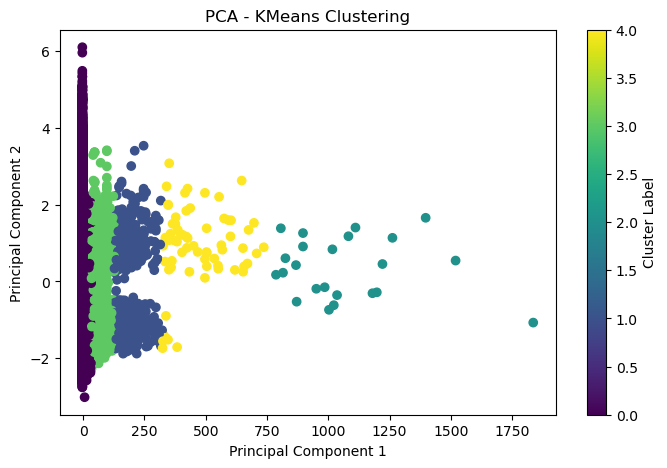

In [12]:
# using PCA and plot the result
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_transformed.drop(columns='cluster'))

plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('PCA - KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [13]:
# Cluster the data whose n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_numeric['cluster'] = kmeans.fit_predict(df_transformed)
df_train = pd.merge(df_train, df_numeric[['customer_unique_id', 'cluster']], on='customer_unique_id', how='left')

cluster_1 = df_train[df_train['cluster'] == 0]
cluster_2 = df_train[df_train['cluster'] == 1]
cluster_3 = df_train[df_train['cluster'] == 2]

print(cluster_1.shape, cluster_2.shape, cluster_3.shape)

(90941, 27) (51, 27) (1641, 27)


In [14]:
cluster_1.head()

,customer_unique_id,frequency,repeater,fo_order_id,fo_customer_id,fo_order_status,fo_order_purchase_timestamp,fo_order_approved_at,fo_order_delivered_carrier_date,fo_order_delivered_customer_date,...,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,fo_product_category_name,customer_in_sao_paulo,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,...,141.90,1,1,-5.0,5.0,0.0,0,bed_bath_table,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,...,27.19,1,1,-5.0,4.0,0.0,0,health_beauty,1,0.0
2,0000f46a3911fa3c0805444483337064,1,0,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,...,86.22,1,1,-2.0,3.0,0.0,0,stationery,0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,...,43.62,1,1,-12.0,4.0,0.0,0,telephony,0,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,0,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,...,196.89,1,1,-8.0,5.0,0.0,0,telephony,1,0.0


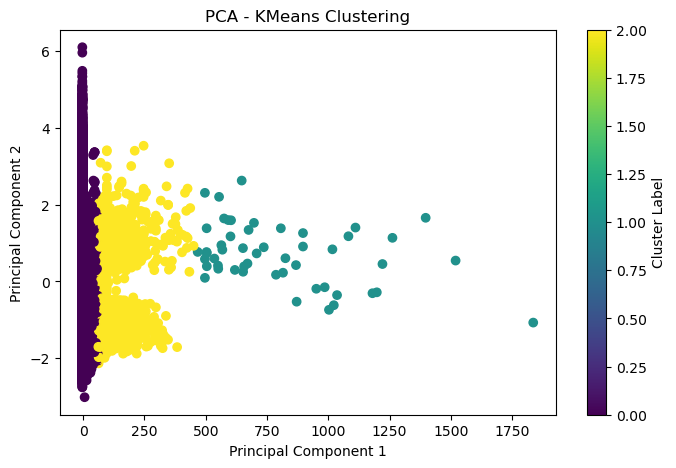

In [15]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_transformed.drop(columns='cluster'))

plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('PCA - KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [16]:
# save each clusters in clusters folder
cluster_1.to_csv('../clusters/cluster_1.csv', index=False)
cluster_2.to_csv('../clusters/cluster_2.csv', index=False)
cluster_3.to_csv('../clusters/cluster_3.csv', index=False)

## Cluster Analysis

In [17]:
print(len(cluster_1))
print(len(cluster_2))
print(len(cluster_3))

90941
51
1641


In [18]:
desc_cluster_1 = cluster_1.describe()
desc_cluster_2 = cluster_2.describe()
desc_cluster_3 = cluster_3.describe()

comparison_df = pd.concat(
    [desc_cluster_1, desc_cluster_2, desc_cluster_3],
    axis=1,
    keys=['Cluster 1', 'Cluster 2', 'Cluster 3']
)

comparison_df

Cluster 1                                                       \
          frequency      repeater customer_zip_code_prefix       recency   
count  90941.000000  90941.000000             90941.000000  90941.000000   
mean       1.034231      0.030767             35245.060314    285.610352   
std        0.207524      0.172687             29873.800822    152.585378   
min        1.000000      0.000000              1003.000000     13.000000   
25%        1.000000      0.000000             11355.000000    162.000000   
50%        1.000000      0.000000             24445.000000    267.000000   
75%        1.000000      0.000000             59086.000000    394.000000   
max        9.000000      1.000000             99980.000000    744.000000   

                                                                  \
           monetary     rfm_score fo_payment_value fo_is_daytime   
count  90941.000000  90941.000000     90941.000000  90941.000000   
mean     164.516691      0.537865       159.398733      0.905807   
std      227.233715      0.644911       219.204986      0.292099   
min        9.590000      0.000000         9.590000      0.000000   
25%       62.410000      0.000000        61.270000      1.000000   
50%      107.100000      0.000000       104.620000      1.000000   
75%      181.660000      1.000000       175.870000      1.000000   
max    13664.080000      3.000000     13664.080000      1.000000   

                                            ...    Cluster 3                   \
      fo_is_weekday fo_delivery_delay_days  ...    rfm_score fo_payment_value   
count  90941.000000           90941.000000  ...  1641.000000      1641.000000   
mean       0.770115             -11.880725  ...     0.531383       168.624637   
std        0.420761              10.098338  ...     0.593991       138.874053   
min        0.000000            -147.000000  ...     0.000000        65.340000   
25%        1.000000             -17.000000  ...     0.000000        96.200000   
50%        1.000000             -12.000000  ...     0.000000       132.460000   
75%        1.000000              -7.000000  ...     1.000000       194.950000   
max        1.000000             188.000000  ...     3.000000      2323.250000   

                                                                               \
      fo_is_daytime fo_is_weekday fo_delivery_delay_days fo_review_score_mean   
count   1641.000000   1641.000000            1641.000000          1641.000000   
mean       0.903108      0.778184             -12.440585             4.056673   
std        0.295901      0.415595              11.206935             1.354133   
min        0.000000      0.000000             -71.000000             1.000000   
25%        1.000000      1.000000             -18.000000             4.000000   
50%        1.000000      1.000000             -13.000000             5.000000   
75%        1.000000      1.000000              -8.000000             5.000000   
max        1.000000      1.000000             123.000000             5.000000   

                                                                              
      fo_voucher_payment_value fo_voucher_used customer_in_sao_paulo cluster  
count              1641.000000          1641.0           1641.000000  1641.0  
mean                129.712431             1.0              0.377209     2.0  
std                  66.040860             0.0              0.484836     0.0  
min                  65.320000             1.0              0.000000     2.0  
25%                  86.660000             1.0              0.000000     2.0  
50%                 101.730000             1.0              0.000000     2.0  
75%                 150.000000             1.0              1.000000     2.0  
max                 453.740000             1.0              1.000000     2.0  

[8 rows x 45 columns]

In [19]:
# Compare a feature between clusters
feature_name = 'repeater'
comparison_df.loc[:, (slice(None), feature_name)]


,Cluster 1,Cluster 2,Cluster 3
,repeater,repeater,repeater
count,90941.000000,51.000000,1641.000000
mean,0.030767,0.058824,0.030469
std,0.172687,0.237635,0.171927
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000
